Practical: $k$-Means Clustering
==


<div class="alert alert-block alert-info"> <b>NOTE</b> 
    
Before we embark on this practical, I wanted to highlight the difference between *clustering* and *classification*. This practical is focused on a technique for **clustering** (we covered classification in the last block).

In general, with clustering, we *don't know* what the *"correct"* clustering for a set of points is; indeed, there may not *be* a definitively "correct" clustering. In several of the examples below, we are using datasets (either artificially created, or loaded in) where the points do, in fact, belong to some class. This is simply a convenience to ensure that we have data where the algorithm will find some clusters. In the examples below, we can compare the cluster number (found by the algorithm) to the "hidden" actual class (that we didn't feed into the algorithm) to see how well the algorithm finds clusters. Usually you won't have this luxury... The whole point of the clustering algorithm is to expose a hidden underlying pattern. Normally, to assess the quality of the clustering, you have to fall back on metrics like in-cluster sum of squares. Even more important than these metrics, if you're *really* doing Exploratory Data Analysis, is to ask whether the clusters suggest anything to you about the data or give you a segmentation that's useful for you to work with.
    
</div>

In this practical, we'll first look at a version of the $k$-means algorithm that we've written ourselves (part 1). You can look at this code to see how this works, and to see how it relates to the algorithm described in the videos. The idea here is to help you see how this algorithm could be implemented. In part 2, we'll show you how to use $k$-means from `scikit-learn`. In practice, this is how you will normally use $k$-means: you will use an established implementation that is known to be correct and to perform well. In parts 1 and 2, you will we working with an artifical dataset that has been constructed to help you explore the algorithm. In part 3, you will run the algorithm in a real (albeit small and controlled) dataset.

-----

PART 1 - Hard coded k-means
--

### Implementing $k$-means
- In this first part of the practical we're going to implement $k$-means from scratch based on what we learnt in the lecture.
- The file `MyKmeans.py` contains code that implements $k$-means clustering.
- Open the file and go through the function making sure you understand what every step does.

Let's first simulate some data to use in our clustering and plot them using a scatter plot:

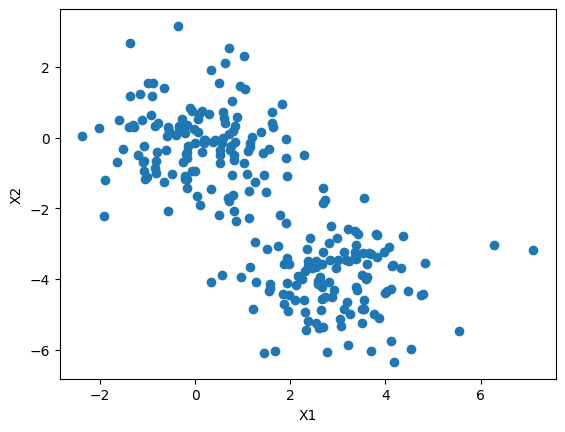

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2) #setting a seed ensures that the clustering is reproducible
data=np.random.normal(size=250*2).reshape(250,2)
data[0:124,0]=data[0:124,0]+3
data[0:124,1]=data[0:124,1]-4

plt.xlabel("X1")
plt.ylabel("X2")
plt.scatter(data[:,0],data[:,1])

Now let's run `MyKmeans()` on this dataset and see if we identify the two clusters:

In [2]:
from MyKmeans import MyKmeans #this runs the contents of the file MyKeans.py that you examined above

            0         1  cluster
0    2.583242 -4.056267      0.0
1    0.863804 -2.359729      1.0
2    1.206564 -4.841747      0.0
3    3.502881 -5.245288      0.0
4    1.942048 -4.909008      0.0
..        ...       ...      ...
245 -1.903821 -1.198140      1.0
246 -0.910066  1.176454      1.0
247  0.299211  0.679267      1.0
248 -0.017661  0.236041      1.0
249  0.494036  1.546278      1.0

[250 rows x 3 columns]


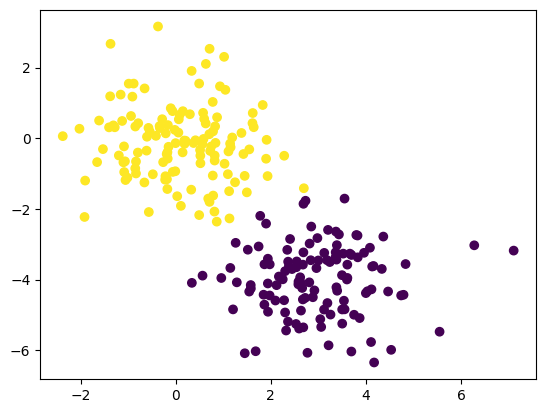

In [3]:
import pandas as pd
data_df=pd.DataFrame(data)
MyRes2 = MyKmeans(df=data_df,n_cluster=2, c_initial=range(2))
print(MyRes2)
plt.scatter(MyRes2.iloc[:,0],MyRes2.iloc[:,1], c=MyRes2.iloc[:,2])

From visual inspection it looks like $k$-means has done a pretty good job in separating the data into clusters.

Use `crosstab()` from Pandas to compare the clusters' allocation with the true clusters.

<div class="alert alert-block alert-info"> <b>REMEMBER: </b> When you're doing this for real, you won't know what the "true clusters" are, or whether there even is some underlying class that these features correspond to! </div> 


In [4]:
true=list([0]*125+[1]*125) #construct a list with "true" cluster number
pd.crosstab(MyRes2.cluster,true, colnames=["True"], rownames=["kmeans"])

True,0,1
kmeans,,
0.0,120,0
1.0,5,125


Has it grouped all points correctly?

Run the above for different numbers of clusters by adjusing `n_cluster` and `c_initial` and see how the clusters change.

In [6]:
#answer


We've seen in the lecture that $k$-means tries to minimize the total within cluster sum of squares. The `calculateSS` function takes as intput the results of MyKmeans and calculates the total sum of squares within clusters and the total sum of squares between clusters.

Go through the function and make sure you understand how it works and the differences between each quantity.

In [5]:
#Function calculateSS() 
#  Input: output from MyKmeans()
#  Output: dataframe with Total within clusters, Between and Total Sum of Squares.

def calculateSS(res_clusters):
    
    #Create a list with enough elements to store a number for each cluster referenced 
    Within_SS = [0]*int(res_clusters.iloc[:,res_clusters.shape[1]-1].max()+1)
    
    Total_SS = sum(res_clusters.iloc[:,0:res_clusters.shape[1]-1].apply(lambda x: sum((x-x.mean())**2), axis=1))
    
    for i in pd.unique(res_clusters.iloc[:,res_clusters.shape[1]-1]):
        i=int(i)
        df=res_clusters[res_clusters.cluster==i]
        Within_SS[i] = sum(df.iloc[:,0:df.shape[1]-1].apply(lambda x: sum((x-x.mean())**2)))
    
    Total_Within_SS = sum(Within_SS)
    
    Between_SS = Total_SS-Total_Within_SS
    
    res=pd.DataFrame([[Total_Within_SS,Between_SS,Total_SS]])
    res.columns=["Tot_Within","Between","Total"]
    
    return(res)
    

In [6]:
calculateSS(MyRes2)

,Tot_Within,Between,Total
0,525.040522,2663.309426,3188.349948


In our example, we know that there are 2 clusters by construction. If we didn't, how would we choose $k$?

We'd need to run `MyKmeans` for various values of $k$ and choose the one after which the change in the total sum of squares within clusters becomes very small.

Let's write a function that iteratively changes $k$ and each time calculates the total within clusters sum of squares using our `calculateSS()` function:

In [7]:
def choose_k(max_k, data):
    #create placeholder lists with the correct number of elements
    res = [0] * (max_k+1)
    MySS = [0] * (max_k+1)
    for i in range(1,max_k+1):
        print("Trying k means with ",i," clusters")
        res[i]=MyKmeans(df=data, n_cluster=i, c_initial=range(i))
        MySS[i]=calculateSS(res_clusters=res[i])
    return MySS[1:max_k+1]

Run the function on `data_df` for up to 10 clusters and plot the results:

In [8]:
k=10
k_res=choose_k(max_k=k, data=data_df)
k_res=pd.concat(k_res, ignore_index=True)

Trying k means with  1  clusters
Trying k means with  2  clusters
Trying k means with  3  clusters
Trying k means with  4  clusters
Trying k means with  5  clusters
Trying k means with  6  clusters
Trying k means with  7  clusters
Trying k means with  8  clusters
Trying k means with  9  clusters
Trying k means with  10  clusters


In [9]:
k_res

,Tot_Within,Between,Total
0,1964.268018,1224.081930,3188.349948
1,525.040522,2663.309426,3188.349948
2,453.781471,2734.568477,3188.349948
3,395.560995,2792.788953,3188.349948
4,365.874121,2822.475827,3188.349948
5,346.144405,2842.205543,3188.349948
6,334.341130,2854.008818,3188.349948
7,310.480209,2877.869739,3188.349948
8,290.051218,2898.298730,3188.349948
9,282.953776,2905.396172,3188.349948


Text(0, 0.5, 'Total Within SS')

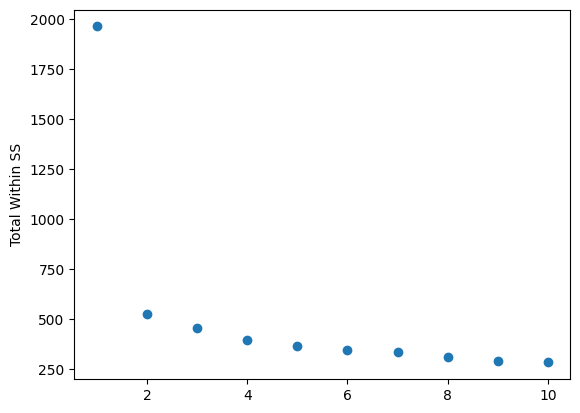

In [10]:
import matplotlib.pyplot as plt
plt.plot(range(1,11),k_res['Tot_Within'], 'o')
plt.ylabel("Total Within SS")

Looking at the above plot, would anything stop you choosing $k=3$? $k=2$ is probably better here, but it's not always clear exaclty where the 'elbow' is in plots like this.

Run `MyKmeans()` for 3 and 4 clusters and plot the results.



In [13]:
#answer


In [14]:
#answer


PART 2 - Using kmeans from scikit-learn
--

Most of the things we've done so far can easily be done using the `KMeans` function from `scikit-learn`. The [scikit-learn project](https://scikit-learn.org/) provides implementations of many useful machine learning algorithms. 

In [11]:
from sklearn.cluster import KMeans

Look at the help file for KMeans:

In [12]:
?KMeans

Init signature:
KMeans(
    n_clusters=8,
    *,
    init='k-means++',
    n_init='auto',
    max_iter=300,
    tol=0.0001,
    verbose=0,
    random_state=None,
    copy_x=True,
    algorithm='lloyd',
)
Docstring:     
K-Means clustering.

Read more in the :ref:`User Guide <k_means>`.

Parameters
----------

n_clusters : int, default=8
    The number of clusters to form as well as the number of
    centroids to generate.

    For an example of how to choose an optimal value for `n_clusters` refer to
    :ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.

init : {'k-means++', 'random'}, callable or array-like of shape             (n_clusters, n_features), default='k-means++'
    Method for initialization:

    * 'k-means++' : selects initial cluster centroids using sampling             based on an empirical probability distribution of the points'             contribution to the overall inertia. This technique speeds up             convergence. The algorithm imple

To run scikit-learn's KMeans() on our data for two clusters using the same initial centroids as we did before, run the following:

In [14]:
model=KMeans(n_clusters=2,init=data_df.iloc[0:2,:],max_iter=40, algorithm="lloyd")
Skmeans0=model.fit(data_df)
Skmeans0

KMeans(init=          0         1
0  2.583242 -4.056267
1  0.863804 -2.359729,
       max_iter=40, n_clusters=2)

You can see the which clusters the points are assigned to:

In [15]:
Skmeans0.predict(data_df)

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

The total within sum of squares can be obtained as follows:

In [16]:
Skmeans0.inertia_

523.3798951150472

Unfortunately, scikit-learn does not provide a way to directly access values for between-sum-of-squares and total-sum-of-squares.

Positions of the centroids can be obtained as follows:

In [17]:
Skmeans0.cluster_centers_

array([[ 2.95458524, -3.9871701 ],
       [ 0.08196757, -0.13672734]])

You don't have to specify the initial centroids. You can let scikit learn find these. (Indeed, this is what it expects by default, which is why you may have received a warning above). For reproducible results, you can set the seed for random_state:

In [18]:
model=KMeans(n_clusters=2,max_iter=40, random_state=777777, algorithm="lloyd")
Skmeans0=model.fit(data_df)
Skmeans0

KMeans(max_iter=40, n_clusters=2, random_state=777777)

Compare the results with those obtained from our implementation.

`KMeans` runs the algorithm multiple times using different starting centroids (10, by default) and returns the one with the best results. 

It's good practice to try different starting centroids as the clustering results can depend on these. You can change the number of starting centroids that are used using the `n_init` parameter:

In [19]:
model=KMeans(n_clusters=2, n_init=20, max_iter=40, random_state=777777, algorithm="lloyd")
Skmeans0=model.fit(data_df)
Skmeans0

KMeans(max_iter=40, n_clusters=2, n_init=20, random_state=777777)

Specifying `algorithm="lloyd"` implements _k_-means almost identically to our written implementation.

Alternative `KMeans()` implementations are available in scikit-learn that can be more robust than ours.

Let's use scikit-learn's default option for this and slight alter our `choose_k` function to use this

In [20]:
def Schoose_k(max_k, data):
    #create placeholder lists with the correct number of elements
    res = [0] * (max_k+1)
    MySS = [0] * (max_k+1)
    for i in range(1,max_k+1):
        print("Trying k means with ",i," clusters")
        model=KMeans(n_clusters=i, n_init=20, max_iter=40, random_state=777777)
        Skmeans0=model.fit(data_df)
        res[i]=Skmeans0.inertia_
    return res[1:max_k+1]

Run the above updated version using,

In [21]:
Sk_res = Schoose_k(max_k=k, data=data_df)

Trying k means with  1  clusters
Trying k means with  2  clusters
Trying k means with  3  clusters
Trying k means with  4  clusters
Trying k means with  5  clusters
Trying k means with  6  clusters
Trying k means with  7  clusters
Trying k means with  8  clusters
Trying k means with  9  clusters
Trying k means with  10  clusters


Let's plot the results along with ours and compare,

Text(0, 0.5, 'Total Within SS')

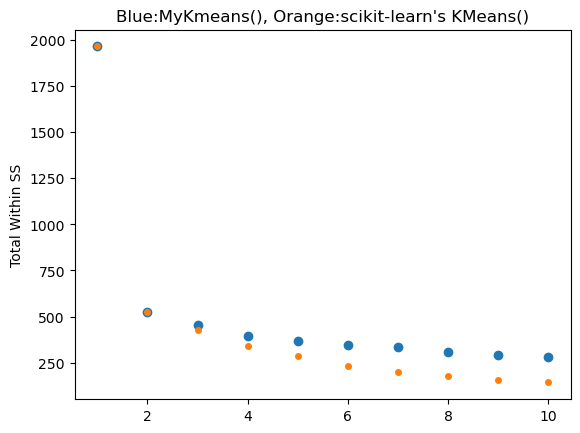

In [25]:
plt.title("Blue:MyKmeans(), Orange:scikit-learn's KMeans()")
plt.plot(range(1,11),k_res['Tot_Within'], 'o')
plt.ylabel("Total Within SS")
plt.plot(range(1,11),Sk_res, 'o', markersize=4)
plt.ylabel("Total Within SS")

Let's use $k=2$ again and run kmeans() to get the clustering results

In [22]:
S_res = KMeans(n_clusters=2, n_init=20, max_iter=40, random_state=777777).fit_predict(data_df)

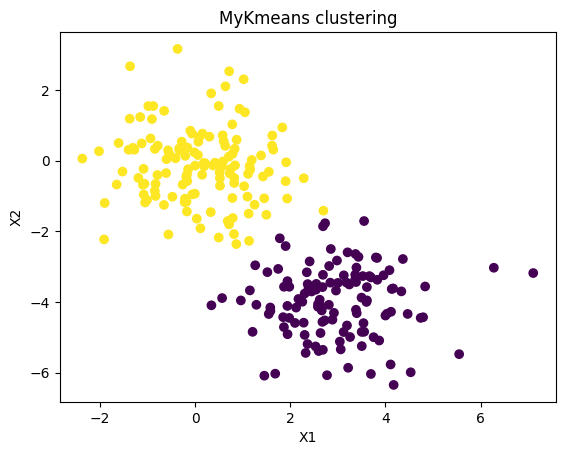

In [23]:
plt.title("MyKmeans clustering")
plt.xlabel("X1")
plt.ylabel("X2")
plt.scatter(MyRes2.iloc[:,0],MyRes2.iloc[:,1], c=MyRes2.iloc[:,2])

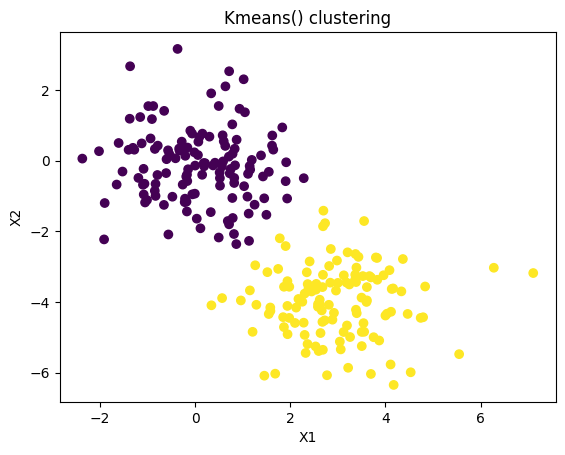

In [24]:
plt.title("Kmeans() clustering")
plt.xlabel("X1")
plt.ylabel("X2")
plt.scatter(data_df.iloc[:,0], data_df.iloc[:,1],c=S_res)

What do you notice in the above plots?

Are the results obtained the same?

PART 3 - KMeans() on the iris dataset
--

The iris dataset is often used to illustrate clustering and classification. It's one of the datasets that's built into _R_ and it's also available in sklearn.datasets.

The dataset contains the length and width of sepals and petals of different flowers of 3 different species: virginica, versicolor and setosa.

In the plot below, the colour corresponds to the flower family of each observation:

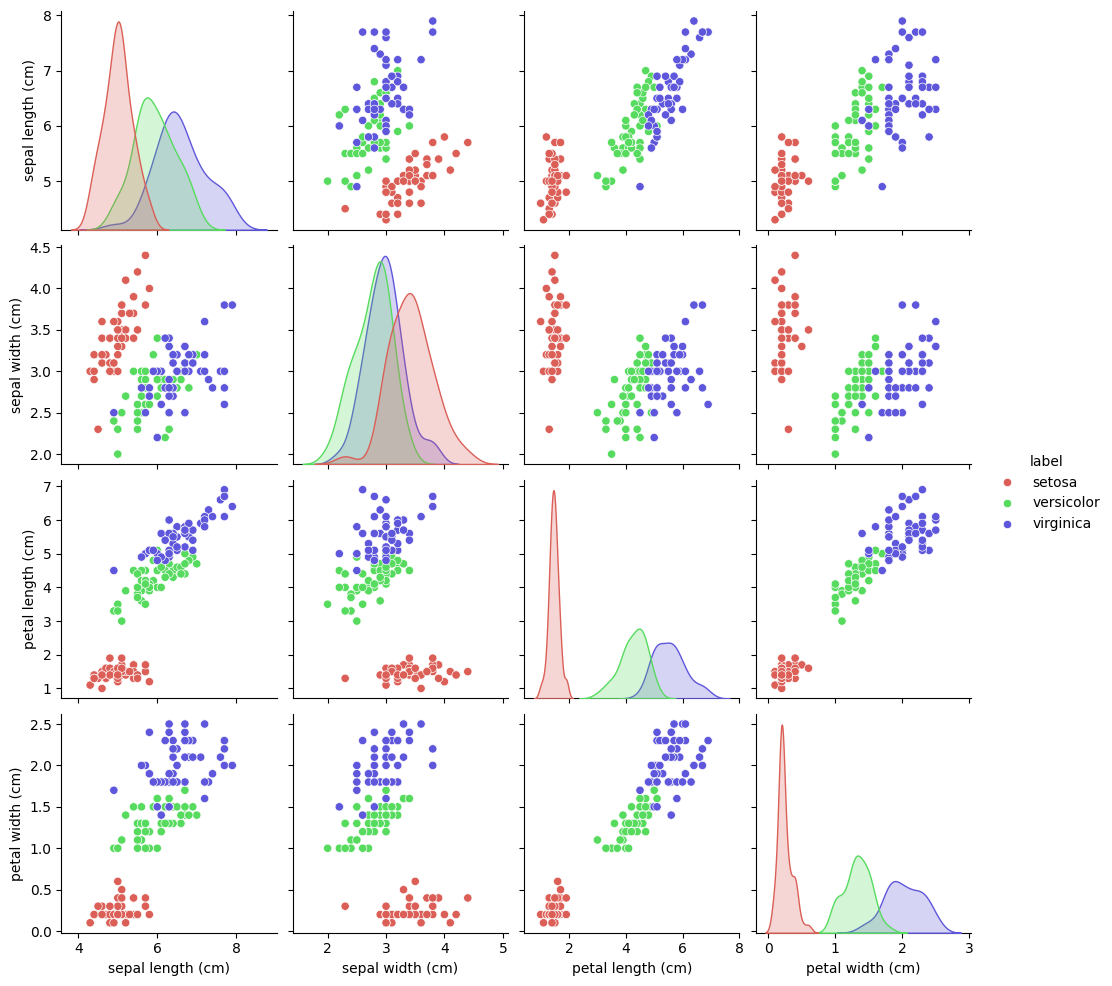

In [25]:
import seaborn as sns           # the seaborn library provides a good function for making pair plots
import sklearn.datasets as skd  # we use sklearn.datasets to get the iris dataset

iris=skd.load_iris()
iris_df=pd.DataFrame(iris.data)
iris_df.columns=iris.feature_names
iris_df['label']=[iris.target_names[t] for t in iris.target]

palette=sns.color_palette("hls", 3) # gives a red-green-blue colour palette
sns.pairplot(iris_df, hue='label', palette=palette)


As we see below, the dataset has 50 observations from each species

In [26]:
iris_df['label'].value_counts()

setosa        50
versicolor    50
virginica     50
Name: label, dtype: int64

Looking at the pair plot above, could kmeans distinguish between the 3 species? Is there any one with which it could struggle?

Let's try kmeans on the iris dataset using the true cluster number

In [27]:
cl_iris=KMeans(n_clusters=3, n_init=20, max_iter=100, random_state=777777).fit_predict(iris_df.iloc[:,0:4])

In [28]:
iris_df['cluster_label']=cl_iris

Plot the data and colour the points by the assigned clusters. How do the results compare to the true groups? **NOTE:** the colour-cluster combination will not align with those of the previous plot.

In [33]:
#answer


Has _k_-means done a good job?

Compare the true class and the assigned clusters using [`crosstab` from Pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html).

In [34]:
#answer

Now try scaling your data first before applying kmeans.

In [35]:
from sklearn.preprocessing import scale
iris_scaled=scale(iris.data)

Look at the help file of `scale` if you're not sure what it's doing.

Run kmeans() on the scaled dataset, using the same seed, and store the results in cl_iris_scaled

In [36]:
#answer


Compare with the results from k_iris and the true labels.

In [39]:
#answer
#comparing with unscaled data

In [38]:
#answer
#comparing with the true labels

Have the results changed? Has there been any improvement?

_Normally_ you would expect scaling to improve the clustering. In fact, in this case, the clustering was already very successful, so it's possible that scaling will actually have a negative effect.

Run `Schoose_k` for a series of k values. Would you have chosen $k=3$?

---
## Acknowledgements and Reuse
<p>
<small>
Python version by Adam Carter, EPCC, The University of Edinburgh, based on an R version previously created at EPCC, The University of Edinburgh.
</small>
</p>
<p>
<small>
&copy; 2023 EPCC, The University of Edinburgh
</small>
</p>
<p>
<small>
You are welcome to re-use this notebook and its contents under the terms of CC-BY-4.0
</small>